In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-stock-price-from-19802021/AAPL.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

2025-08-19 14:00:49.325282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755612049.573435      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755612049.644877      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [5]:
df.shape

(10468, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [7]:
df['Date']=pd.to_datetime(df['Date'])

In [8]:
# making the 'Date' col as index
df.set_index('Date', inplace = True)

In [9]:
# sorting index
df.sort_index(inplace=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])

In [12]:
scaler_values

array([[4.30950014e-04, 4.33270567e-04, 4.42511906e-04, 4.35483696e-04,
        3.40815838e-04, 6.31981003e-02],
       [3.97331936e-04, 3.96658463e-04, 4.05118893e-04, 3.98684579e-04,
        3.12018225e-04, 2.36989104e-02],
       [3.48427437e-04, 3.47836857e-04, 3.55255959e-04, 3.49613594e-04,
        2.73615897e-04, 1.42459064e-02],
       ...,
       [7.35239774e-01, 7.50670228e-01, 7.37757535e-01, 7.44010911e-01,
        7.46069029e-01, 1.23332565e-02],
       [7.23135563e-01, 7.23604845e-01, 7.20334206e-01, 7.14499102e-01,
        7.16477939e-01, 1.45687326e-02],
       [7.12126738e-01, 7.27377614e-01, 7.24634207e-01, 7.22742631e-01,
        7.24743614e-01, 1.80712734e-02]])

In [13]:
df_scaled = pd.DataFrame(scaler_values
                        , columns=df.columns
                        , index=df.index)

In [14]:
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.000431,0.000433,0.000443,0.000435,0.000341,0.063198
1980-12-15,0.000397,0.000397,0.000405,0.000399,0.000312,0.023699
1980-12-16,0.000348,0.000348,0.000355,0.000350,0.000274,0.014246
1980-12-17,0.000361,0.000363,0.000371,0.000365,0.000286,0.011647
1980-12-18,0.000379,0.000381,0.000390,0.000383,0.000300,0.009897


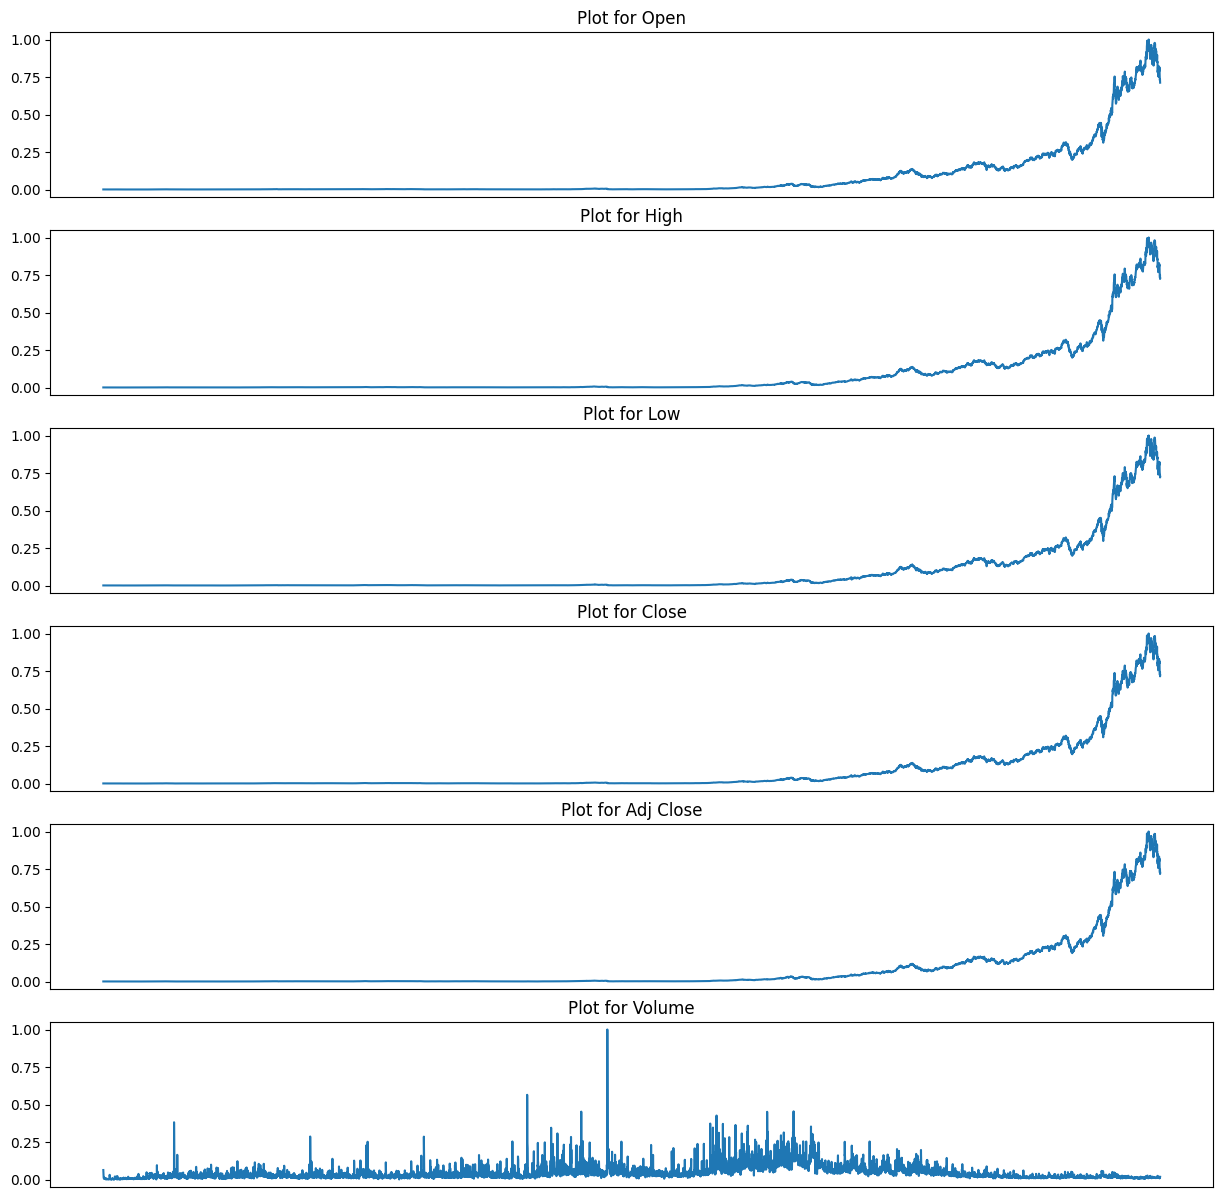

In [15]:
plt.rcParams['figure.figsize']=(15,15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, df_scaled.columns):
    ax.plot(df_scaled[col])
    ax.set_title(f'Plot for {col}')
    ax.axes.xaxis.set_visible(False)

### Creating Sliding window

In [16]:
def create_sequence(data, sliding_window):
    X, y = [], []

    for i in range(sliding_window, len(data)):
        X.append(data.iloc[i-sliding_window:i].values)
        y.append(data.iloc[i].values)

    return np.array(X), np.array(y)

In [17]:
X, y = create_sequence(df_scaled, 100)

In [18]:
X.shape, y.shape

((10368, 100, 6), (10368, 6))

##### Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 29)

In [20]:
X_train.shape, y_train.shape

((8294, 100, 6), (8294, 6))

#### Builing LSTM Model

In [21]:
model = keras.Sequential([
    # 1st LSTM Layer
    keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # 2nd LSTM Layer
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),

    # 3rd LSTM Layer
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Dense Layer
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),

    # 4th LSTM Layer
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Final Dense Layer
    keras.layers.Dense(y_train.shape[1])
])

2025-08-19 14:01:06.468149: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,342 (556.02 KB)

 Trainable params: 142,342 (556.02 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile model
model.compile(optimizer='adam'
             , loss='mae'
             , metrics=['RootMeanSquaredError']
             )

In [24]:
# early stopping, when we see for some consecutive epochs model is not learning, loss remins same, will terminate
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss'
                                          , patience = 10
                                          , restore_best_weights = True)

In [25]:
training=model.fit(X_train, y_train,
                  validation_split=0.2
                  , epochs = 50
                  , batch_size = 40
                  , callbacks = [early_stop])

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 45s 204ms/step - RootMeanSquaredError: 0.0589 - loss: 0.0238 - val_RootMeanSquaredError: 0.0370 - val_loss: 0.0169
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - RootMeanSquaredError: 0.0378 - loss: 0.0158 - val_RootMeanSquaredError: 0.0422 - val_loss: 0.0218
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - RootMeanSquaredError: 0.0349 - loss: 0.0152 - val_RootMeanSquaredError: 0.0215 - val_loss: 0.0102
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - RootMeanSquaredError: 0.0313 - loss: 0.0137 - val_RootMeanSquaredError: 0.0180 - val_loss: 0.0076
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - RootMeanSquaredError: 0.0322 - loss: 0.0142 - val_RootMeanSquaredError: 0.0216 - val_loss: 0.0087
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - RootMeanSquaredError: 0.0295 - loss: 0.0127 - val_RootMeanSquaredError: 0.0184 - val_loss: 0.0074
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - RootMeanSquar

In [26]:
predictions = model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step


In [27]:
predictions= scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

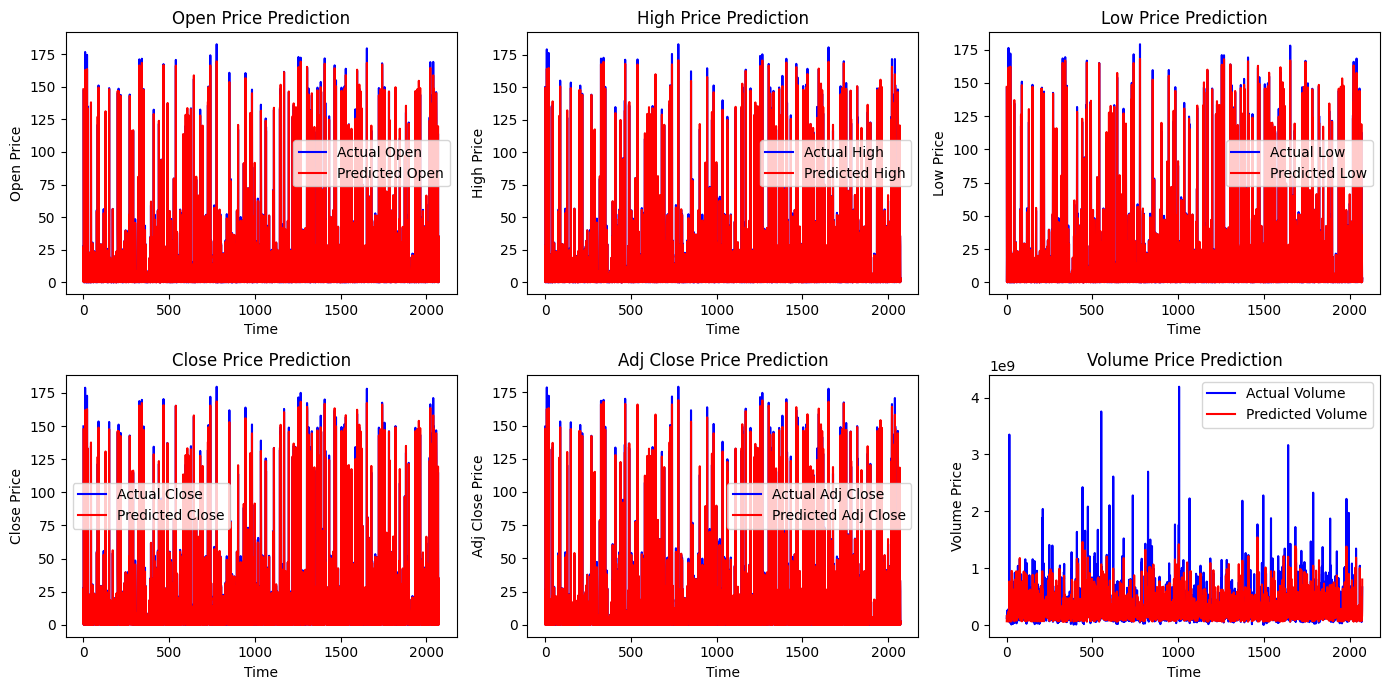

In [28]:
plt.figure(figsize=(14,7))

for i, col in enumerate(df_scaled.columns):
    plt.subplot(2, 3, i+1)
    plt.plot(y_test_rescaled[:,i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:,i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()